In [1]:

import cv2 
import numpy as np  
import pandas as pd 
from sklearn.cluster import KMeans
from collections import Counter
#import imutils
import pprint
from matplotlib import pyplot as plt

In [15]:
### takes screenshot of face 
cap = cv2.VideoCapture(0)
ret,frame = cap.read() # return a single frame in variable `frame`

while(True):
    cv2.imshow('img1',frame) #display the captured image
    
    if cv2.waitKey(1) & 0xFF == ord('y'): #save on pressing 'y' 
        cv2.imwrite('faceshot.png',frame)
        cv2.destroyAllWindows()
        break

cap.release() 
### screenshot saved in folder 

In [16]:
image = cv2.imread('faceshot.png')

In [17]:
def extractSkin(image):
    # Taking a copy of the image
    #img = image.copy()
    # Converting from BGR Colours Space to HSV 
    img = image.copy()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Defining HSV Threadholds
    lower_threshold = np.array([0, 48, 80], dtype=np.uint8)
    upper_threshold = np.array([20, 255, 255], dtype=np.uint8)

    # Single Channel mask,denoting presence of colours in the about threshold
    skinMask = cv2.inRange(img, lower_threshold, upper_threshold)

    # Cleaning up mask using Gaussian Filter
    skinMask = cv2.GaussianBlur(skinMask, (3, 3), 0)

    # Extracting skin from the threshold mask
    skin = cv2.bitwise_and(img, img, mask=skinMask)

    # Return the Skin image
    return cv2.cvtColor(skin, cv2.COLOR_HSV2BGR) 





In [18]:
def removeBlack(estimator_labels, estimator_cluster):

    # Check for black
    hasBlack = False

    # Get the total number of occurance for each color
    occurance_counter = Counter(estimator_labels)

    # Quick lambda function to compare to lists
    def compare(x, y): return Counter(x) == Counter(y)

    # Loop through the most common occuring color
    for x in occurance_counter.most_common(len(estimator_cluster)):

        # Quick List comprehension to convert each of RBG Numbers to int
        color = [int(i) for i in estimator_cluster[x[0]].tolist()]

        # Check if the color is [0,0,0] that if it is black
        if compare(color, [0, 0, 0]) == True:
            # delete the occurance
            del occurance_counter[x[0]]
            # remove the cluster
            hasBlack = True
            estimator_cluster = np.delete(estimator_cluster, x[0], 0)
            break

    return (occurance_counter, estimator_cluster, hasBlack)

In [19]:
def getColorInformation(estimator_labels, estimator_cluster, hasThresholding=False):

    # Variable to keep count of the occurance of each color predicted
    occurance_counter = None

    # Output list variable to return
    colorInformation = []

    # Check for Black
    hasBlack = False

    # If a mask has be applied, remove th black
    if hasThresholding == True:

        (occurance, cluster, black) = removeBlack(
            estimator_labels, estimator_cluster)
        occurance_counter = occurance
        estimator_cluster = cluster
        hasBlack = black

    else:
        occurance_counter = Counter(estimator_labels)

    # Get the total sum of all the predicted occurances
    totalOccurance = sum(occurance_counter.values())

    # Loop through all the predicted colors
    for x in occurance_counter.most_common(len(estimator_cluster)):
        index = (int(x[0]))

        # Quick fix for index out of bound when there is no threshold
        index = (index-1) if ((hasThresholding & hasBlack)
                              & (int(index) != 0)) else index

        # Get the color number into a list
        color = estimator_cluster[index].tolist()

        # Get the percentage of each color
        color_percentage = (x[1]/totalOccurance)

        # make the dictionay of the information
        colorInfo = {"cluster_index": index, "color": color,
                     "color_percentage": color_percentage}

        # Add the dictionary to the list
        colorInformation.append(colorInfo)

    return colorInformation


In [20]:
def extractDominantColor(image, number_of_colors=5, hasThresholding=False):

    # Quick Fix Increase cluster counter to neglect the black(Read Article)
    if hasThresholding == True:
        number_of_colors += 1

    # Taking Copy of the image
    img = image.copy()

    # Convert Image into RGB Colours Space
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Reshape Image
    img = img.reshape((img.shape[0]*img.shape[1]), 3)

    # Initiate KMeans Object
    estimator = KMeans(n_clusters=number_of_colors, random_state=0)

    # Fit the image
    estimator.fit(img)

    # Get Colour Information
    colorInformation = getColorInformation(
        estimator.labels_, estimator.cluster_centers_, hasThresholding)
    return colorInformation

In [21]:
def plotColorBar(colorInformation):
    # Create a 500x100 black image
    color_bar = np.zeros((100, 500, 3), dtype="uint8")

    top_x = 0
    for x in colorInformation:
        bottom_x = top_x + (x["color_percentage"] * color_bar.shape[1])

        color = tuple(map(int, (x['color'])))

        cv2.rectangle(color_bar, (int(top_x), 0),
                      (int(bottom_x), color_bar.shape[0]), color, -1)
        top_x = bottom_x
    return color_bar

In [22]:
def prety_print_data(color_info):
    for x in color_info:
        print(pprint.pformat(x))
        print()

In [23]:
#image = imutils.resize(image, width=250)


Text(0.5, 1.0, 'Original Image')

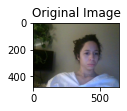

In [24]:
plt.subplot(3, 1, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Original Image")
# plt.show()

Text(0.5, 1.0, 'Thresholded  Image')

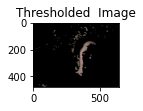

In [25]:
# Apply Skin Mask

skin = extractSkin(image)


plt.subplot(3, 1, 2)
plt.imshow(cv2.cvtColor(skin, cv2.COLOR_BGR2RGB))
plt.title("Thresholded  Image")
# plt.show()


In [26]:
# Find the dominant color. Default is 1 , pass the parameter 'number_of_colors=N' where N is the specified number of colors
dominantColors = extractDominantColor(skin, hasThresholding=True)

In [27]:
# Show in the dominant color information
print("Color Information")
prety_print_data(dominantColors)


Color Information
{'cluster_index': 4,
 'color': [126.57092778686678, 114.2512269221789, 99.34634260341271],
 'color_percentage': 0.31253648569760656}

{'cluster_index': 2,
 'color': [150.96360708534695, 125.48663446054854, 117.11304347826204],
 'color_percentage': 0.22664915353181553}

{'cluster_index': 1,
 'color': [107.12562814070378, 93.78768844221139, 81.83291457286431],
 'color_percentage': 0.17469352014010509}

{'cluster_index': 0,
 'color': [169.1188251001343, 139.52558967512314, 133.2946150422797],
 'color_percentage': 0.16389375364856976}

{'cluster_index': 3,
 'color': [82.89673590504471, 69.64332344213659, 59.961424332344016],
 'color_percentage': 0.1222270869819031}



Color Bar


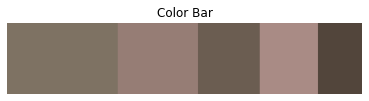

In [28]:
# Show in the dominant color as bar
print("Color Bar")
colour_bar = plotColorBar(dominantColors)
plt.subplot(3, 1, 3)
plt.axis("off")
plt.imshow(colour_bar)
plt.title("Color Bar")

plt.tight_layout()
plt.show()